# Feature Engineering and Exploration

Focus on EPL and create the functions to engineer features

Given the dataset structure (each obs is for Team A vs Team B) functions can be tricky

## 1. Imports



In [1]:
# mixture of libs for web scraping, parsing and pandas
import datetime as dt
from importlib import reload
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import sqlite3

from epl.query import create_and_query
from epl.match_utils import full_table_calculator, league_table_asof, result_calculator, table_calculator
from epl.feature_utils import add_game_week, add_league_pos, add_prev_season_pos, add_result_streak, add_team_result_streak

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')

## 2. Running Count / Sum Feature Engineering

One thing keen to use as a feature is a local history (1, 3, 5, 10, 25 games) running stat for each team

Given we have Home vs Away this is a little tricky but we can make a few helper functions

Variables we care to be able to compute:
 - Last 1,3,5,10, season-to-date:
  - Results (can be points scored or % W, % D, % L)
  - Goals for vs against
 - Position in the league table

### 2a. Query the Premier League Data

In [2]:
# restrict to premier league only for now
div = 'E0'
df_raw = create_and_query('matches', cols=['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR'], wc={'Div': ['=', div]})
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw = df_raw.sort_values('Date', ascending=True)
df_raw.tail()

Running query: SELECT Season, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR FROM matches WHERE Div = 'E0'


,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
35,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H
36,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A
37,2020/2021,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H
33,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H
32,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,A


### 2b. Create GameWeek Columns

It will be helpful to have a GameWeek column for various reasons:
 - Potentially some teams play better/worse at a later stage of the season
 - To group matches by a specifc stage of the season as dates will be spread across weekends

Approach: Create cols, for each season, for each team, label matches and combine on to original df

In [3]:
?? add_game_week

Signature:  add_game_week(match_df)
Docstring: <no docstring>
Source:   
def add_game_week(match_df):

    # create the columns init with nan
    match_df['HomeTeamGameWeek'] = np.nan
    match_df['AwayTeamGameWeek'] = np.nan
    # get col order to apply at end as combine_first changes col order
    df_cols = match_df.columns

    # ensure sorted by date, then create game week by season
    match_df = match_df.sort_values('Date', ascending=True)
    for s in match_df.Season.unique():
        # new df for only that season
        df_s = match_df[match_df.Season == s]
        # for each team assign game week (as already sorted by Date)
        for t in df_s.HomeTeam.unique():
            df_t = df_s[(df_s.HomeTeam == t) | (df_s.AwayTeam == t)]
            df_t['HomeTeamGameWeek'] = [x for x in range(1, len(df_t)+1)]
            df_t['AwayTeamGameWeek'] = [x for x in range(1, len(df_t)+1)]

            # where team is the HomeTeam, set GameWeek else nan, same for away
            df_t['Ho

In [4]:
df = add_game_week(df_raw)
df.tail()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek
35,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H,4.0,4.0
36,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A,3.0,4.0
37,2020/2021,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H,3.0,4.0
33,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H,4.0,4.0
32,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,A,4.0,4.0


### 2c. Create Table Position

Current table positioning will be very helpful to help inform games between top and bottom of the league teams

However it is tricky as we:
 - want the table as of before the game
 - need to calculate the table at each point in the season

In [5]:
?? add_league_pos

Signature:  add_league_pos(match_df)
Docstring: <no docstring>
Source:   
def add_league_pos(match_df):

    # first we need to use the match result data to compute the league tables at each point in time
    # 'point in time' is defined as the max date per game week

    # list to hold all the league tables at each week for each season
    league_tables = []

    # compute for each season
    for s in match_df.Season.unique():
        print("Computing league table for season: {}".format(s))
        # get only matches for that season and get the min game week per match up
        df_s = match_df[match_df.Season == s]
        df_s['MinGameWeek'] = df_s[[
            'HomeTeamGameWeek', 'AwayTeamGameWeek']].min(axis=1)

        # now we get the dates that correspond to each game week
        week_dates = df_s[['Date', 'MinGameWeek']].groupby(
            'MinGameWeek').max().to_dict()['Date']

        # for each week_date we then get the table as of that point in time
        for week, d

In [6]:
df,tables_df = add_league_pos(df)

Computing league table for season: 1993/1994
Computing league table for season: 1994/1995
Computing league table for season: 1995/1996
Computing league table for season: 1996/1997
Computing league table for season: 1997/1998
Computing league table for season: 1998/1999
Computing league table for season: 1999/1900
Computing league table for season: 2000/2001
Computing league table for season: 2001/2002
Computing league table for season: 2002/2003
Computing league table for season: 2003/2004
Computing league table for season: 2004/2005
Computing league table for season: 2005/2006
Computing league table for season: 2006/2007
Computing league table for season: 2007/2008
Computing league table for season: 2008/2009
Computing league table for season: 2009/2010
Computing league table for season: 2010/2011
Computing league table for season: 2011/2012
Computing league table for season: 2012/2013
Computing league table for season: 2013/2014
Computing league table for season: 2014/2015
Computing 

### 2d. Add Previous League Finish

Useful to know where they placed in the league last season as a helpful measure of lomnger run performance

In [7]:
?? add_prev_season_pos

Signature:  add_prev_season_pos(match_df, tables_df, promotion_treatment='20')
Docstring: <no docstring>
Source:   
def add_prev_season_pos(match_df, tables_df, promotion_treatment='20'):

    # create map of season to next season
    season_dict = dict(zip(tables_df.Season.unique(),
                           tables_df.Season.unique()[1:]))
    # get the last game week per season so we only get the end of season tables
    final_tables_df = tables_df[['Season', 'GameWeek']].groupby(
        'Season').max().reset_index()
    # create col for next season mapped from Season
    final_tables_df['NextSeason'] = final_tables_df['Season'].map(season_dict)

    # join onto original tables_df
    new_tables_df = pd.merge(
        left=tables_df, right=final_tables_df, how='left', on=['Season', 'GameWeek'])
    # if not present then not last game week so ditch
    final_tables_df = new_tables_df[~new_tables_df.NextSeason.isna()]
    # rename cols
    final_tables_df = final_tables_df[['Team', '

In [8]:
df = add_prev_season_pos(df, tables_df)
df.tail()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek,HomeTeamPoints,HomeLeagPos,AwayTeamPoints,AwayLeagPos,HomePrevLeagPos,AwayPrevLeagPos
10367,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H,4.0,4.0,6.0,13.0,0.0,20.0,7.0,20.0
10368,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A,3.0,4.0,3.0,14.0,7.0,6.0,3.0,6.0
10369,2020/2021,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H,3.0,4.0,6.0,4.0,9.0,5.0,17.0,1.0
10370,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H,4.0,4.0,6.0,11.0,1.0,17.0,11.0,20.0
10371,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,A,4.0,4.0,9.0,3.0,6.0,10.0,5.0,16.0


### 2e. Add Avg Points Per Game (ppg)

A nice succint measure of a teams performance over the last n games - potentially a better feature than the 2f. win loss draw streaks

In [37]:
?? add_avg_ppg

Signature:  add_avg_ppg(match_df, streak_length)
Docstring: <no docstring>
Source:   
def add_avg_ppg(match_df, streak_length):
    
    orig_cols = list(match_df.columns)
    
    h_map = {'H': 3, 'D': 1, 'A': 0}
    a_map = {'H': 0, 'D': 1, 'A': 3}
    sl = str(streak_length)
    
    # iterate over all the teams in the match_df (every team will play a home game so just just that)
    for team in df.HomeTeam.unique():
        # get the games for that team
        team_df = df[(df.HomeTeam == team) | (df.AwayTeam == team)]
        # now need to compute points for that team per game
        team_df['PPG'] = 0
        team_df.PPG = np.where(team_df.HomeTeam == team, team_df.FTR.map(h_map), team_df.PPG)
        team_df.PPG = np.where(team_df.AwayTeam == team, team_df.FTR.map(a_map), team_df.PPG)
        # compute mean, offset by 1 so we don't include result of current game
        team_df['AvgPPG_'+sl] = team_df.PPG.shift(1).rolling(streak_length).mean().fillna(0)
        # add new cols 

In [38]:
df = add_avg_ppg(df, 3)
df.tail()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek,HomeTeamPoints,HomeLeagPos,AwayTeamPoints,AwayLeagPos,HomePrevLeagPos,AwayPrevLeagPos,HomeAvgPPG_3,AwayAvgPPG_3
10367,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H,4.0,4.0,6.0,13.0,0.0,20.0,7.0,20.0,1.000000,0.000000
10368,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A,3.0,4.0,3.0,14.0,7.0,6.0,3.0,6.0,2.000000,1.333333
10369,2020/2021,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H,3.0,4.0,6.0,4.0,9.0,5.0,17.0,1.0,2.333333,3.000000
10370,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H,4.0,4.0,6.0,11.0,1.0,17.0,11.0,20.0,1.000000,0.333333
10371,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,A,4.0,4.0,9.0,3.0,6.0,10.0,5.0,16.0,3.000000,1.000000


### 2f. Add Win / Loss / Draw Streak Stats

We'd also like some measure of more short term form - for this we need to compute for each team their form over the last n matches

In [39]:
?? add_result_streak

Signature:  add_result_streak(match_df, streak_length)
Docstring: <no docstring>
Source:   
def add_avg_ppg(match_df, streak_length):

    sl = str(streak_length)
    orig_cols = list(match_df.columns)

    h_map = {'H': 3, 'D': 1, 'A': 0}
    a_map = {'H': 0, 'D': 1, 'A': 3}

    # iterate over all the teams in the match_df (every team will play a home game so just just that)
    for team in df.HomeTeam.unique():
        # get the games for that team
        team_df = df[(df.HomeTeam == team) | (df.AwayTeam == team)]
        # now need to compute points for that team per game
        team_df['PPG'] = 0
        team_df.PPG = np.where(team_df.HomeTeam == team,
                               team_df.FTR.map(h_map), team_df.PPG)
        team_df.PPG = np.where(team_df.AwayTeam == team,
                               team_df.FTR.map(a_map), team_df.PPG)
        # compute mean, offset by 1 so we don't include result of current game
        team_df['AvgPPG_' +
                sl] = team_df.PP

In [40]:
?? add_team_result_streak

Signature:  add_team_result_streak(match_df, streak_length, team)
Docstring: <no docstring>
Source:   
def add_avg_ppg(match_df, streak_length):

    sl = str(streak_length)
    orig_cols = list(match_df.columns)

    h_map = {'H': 3, 'D': 1, 'A': 0}
    a_map = {'H': 0, 'D': 1, 'A': 3}

    # iterate over all the teams in the match_df (every team will play a home game so just just that)
    for team in df.HomeTeam.unique():
        # get the games for that team
        team_df = df[(df.HomeTeam == team) | (df.AwayTeam == team)]
        # now need to compute points for that team per game
        team_df['PPG'] = 0
        team_df.PPG = np.where(team_df.HomeTeam == team,
                               team_df.FTR.map(h_map), team_df.PPG)
        team_df.PPG = np.where(team_df.AwayTeam == team,
                               team_df.FTR.map(a_map), team_df.PPG)
        # compute mean, offset by 1 so we don't include result of current game
        team_df['AvgPPG_' +
                sl] =

In [42]:
df = add_result_streak(df, 3)
df.tail()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek,HomeTeamPoints,HomeLeagPos,AwayTeamPoints,AwayLeagPos,HomePrevLeagPos,AwayPrevLeagPos,HomeAvgPPG_3,AwayAvgPPG_3,HomeWStreak_5,HomeDStreak_5,HomeLStreak_5,AwayWStreak_5,AwayDStreak_5,AwayLStreak_5,HomeWStreak_3,HomeDStreak_3,HomeLStreak_3,AwayWStreak_3,AwayDStreak_3,AwayLStreak_3
10367,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H,4.0,4.0,6.0,13.0,0.0,20.0,7.0,20.0,1.000000,0.000000,0.4,0.0,0.6,0.0,0.0,1.0,0.333333,0.000000,0.666667,0.000000,0.000000,1.000000
10368,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A,3.0,4.0,3.0,14.0,7.0,6.0,3.0,6.0,2.000000,1.333333,0.6,0.2,0.2,0.4,0.4,0.2,0.666667,0.000000,0.333333,0.333333,0.333333,0.333333
10369,2020/2021,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H,3.0,4.0,6.0,4.0,9.0,5.0,17.0,1.0,2.333333,3.000000,0.6,0.4,0.0,1.0,0.0,0.0,0.666667,0.333333,0.000000,1.000000,0.000000,0.000000
10370,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H,4.0,4.0,6.0,11.0,1.0,17.0,11.0,20.0,1.000000,0.333333,0.6,0.0,0.4,0.2,0.2,0.6,0.333333,0.000000,0.666667,0.000000,0.333333,0.666667
10371,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,A,4.0,4.0,9.0,3.0,6.0,10.0,5.0,16.0,3.000000,1.000000,0.6,0.0,0.4,0.2,0.4,0.4,1.000000,0.000000,0.000000,0.333333,0.000000,0.666667


## 3. Feature Exploration

Now we have a few features that hopefully can help us to predict. They are broadly:
 - Home or Away: Home Advantage
 - GameWeek in the season: Potentially some teams play better late in the season
 - Current Points and League Position: An indicator of current season performance
 - Previous League Position: An indicator of longer run performance
 - W/L/D Streak: A shorter term measure of team performance

Time to explore how these variables correlate with W/L/D and if we can use combinations of them to start segregating the result space

### 3a. Home Advantage

Traditionally, home vs away is an important factor. Reasons cited:
 - Travel effect (especially if jet lag / time difference)
 - Familiarity with ground - potentially behavioural impact on familiarity reducing need to think about other non-important issues
 - Home crowd / fans

First we can count the results by result type - we would expect net of draws equal W / L if there is no advantage

In [12]:
df[['FTR', 'HomeTeam']].groupby('FTR').count() / len(df)

,HomeTeam
FTR,
A,0.279617
D,0.256408
H,0.463976


So clearly there is a home advantage - 46% of games finish with a win for the HomeTeam vs 28% of wins for the AwayTeam

We can now check if this pattern is:
 - persistent throughout all seasons by binning by season
 - persistent throughout a season by binning game weeks so we form a {start, middle, end} of a season

#### 3a i. Home Advantage Across Seasons

In [13]:
home_adv_df = df[['Season', 'FTR', 'HomeTeam']].groupby(['Season', 'FTR']).count() / df[['Season', 'HomeTeam']].groupby(['Season']).count()
home_adv_piv = pd.pivot_table(data=home_adv_df, columns='Season', index='FTR', values='HomeTeam')
home_adv_piv

Season,1994/1995,1995/1996,1996/1997,1997/1998,1998/1999,1999/1900,2000/2001,2001/2002,2002/2003,2003/2004,2004/2005,2005/2006,2006/2007,2007/2008,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,2016/2017,2017/2018,2018/2019,2019/2020,2020/2021
FTR,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.266234,0.252632,0.260526,0.265789,0.252632,0.265789,0.250000,0.300000,0.271053,0.274627,0.265672,0.292105,0.263158,0.273684,0.289474,0.239474,0.236842,0.305263,0.278947,0.323684,0.302632,0.305263,0.286842,0.284211,0.336842,0.305263,0.500000
D,0.290043,0.257895,0.313158,0.250000,0.302632,0.242105,0.265789,0.265789,0.236842,0.277612,0.286567,0.202632,0.257895,0.263158,0.255263,0.252632,0.292105,0.244737,0.284211,0.205263,0.244737,0.281579,0.221053,0.260526,0.186842,0.242105,0.078947
H,0.443723,0.489474,0.426316,0.484211,0.444737,0.492105,0.484211,0.434211,0.492105,0.447761,0.447761,0.505263,0.478947,0.463158,0.455263,0.507895,0.471053,0.450000,0.436842,0.471053,0.452632,0.413158,0.492105,0.455263,0.476316,0.452632,0.421053


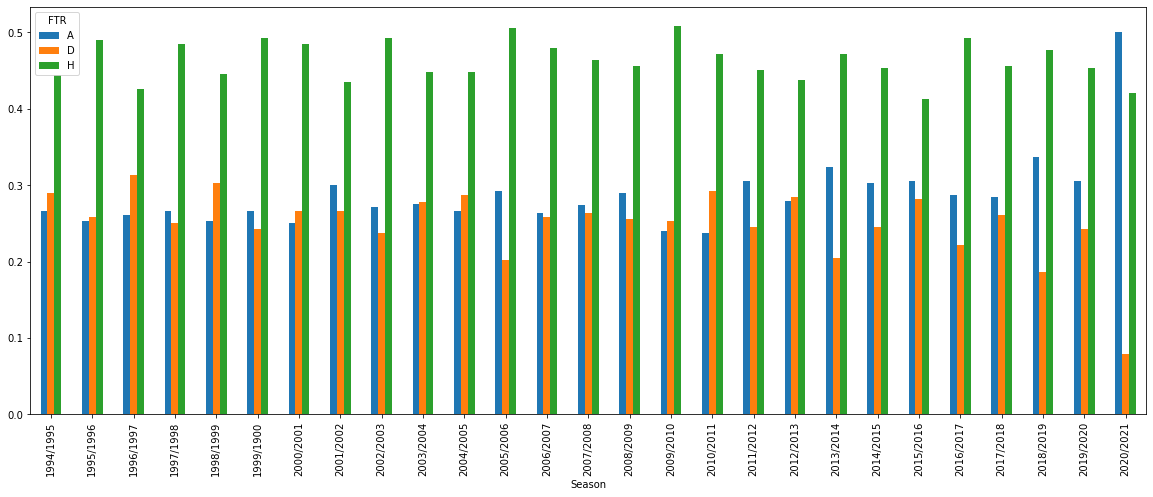

In [14]:
pd.pivot_table(data=home_adv_df, columns='FTR', index='Season', values='HomeTeam').plot(kind='bar', figsize=(20,7.5));

Very little variation in the last 25 years (except this season, 2020/2021, where D --> L) with:
 - Home winning around 45-50% of the time
 - Away winning around 25-30% of the time
 - Draws account for around 25-30%

#### 3a ii. Home Advantage Per Season Stage

Seasons have around 40 games in them --> lets split them up into 3 stages:
 - Beg: Before 15
 - Mid: Before 30
 - End: The rest

In [15]:
home_adv_stage_df = df[['HomeTeam', 'FTR', 'HomeTeamGameWeek']]
home_adv_stage_df['SeasonStage'] = np.where(home_adv_stage_df['HomeTeamGameWeek'] < 15, 'Beg', np.nan)
home_adv_stage_df['SeasonStage'] = np.where((home_adv_stage_df['HomeTeamGameWeek'] < 30) & (home_adv_stage_df['HomeTeamGameWeek'] >=15) , 'Mid', home_adv_stage_df['SeasonStage'])
home_adv_stage_df['SeasonStage'] = np.where(home_adv_stage_df['HomeTeamGameWeek'] >= 30, 'End', home_adv_stage_df['SeasonStage'])
home_adv_stage_df.tail()

,HomeTeam,FTR,HomeTeamGameWeek,SeasonStage
10367,Wolves,H,4.0,Beg
10368,Man United,A,3.0,Beg
10369,Aston Villa,H,3.0,Beg
10370,Southampton,H,4.0,Beg
10371,Leicester,A,4.0,Beg


In [16]:
home_adv_stage_df = home_adv_stage_df[['SeasonStage', 'FTR', 'HomeTeam']].groupby(['SeasonStage', 'FTR']).count() / home_adv_stage_df[['SeasonStage', 'HomeTeam']].groupby(['SeasonStage']).count()
pd.pivot_table(data=home_adv_stage_df, columns='SeasonStage', index='FTR', values='HomeTeam')[['Beg', 'Mid', 'End']]

SeasonStage,Beg,Mid,End
FTR,,,
A,0.287341,0.267109,0.288503
D,0.261589,0.259704,0.242516
H,0.451071,0.473187,0.468980


Again, home advantage appears pretty consistent regardless of what stage of the season we are in

#### 3a iii. Home Advantage By League Position

Potentially the uptick in W at Home varies depending on the quality of the team

It's not uncommon for teams in the top 5 to go on large unbeaten runs at home

As such, does it appear that top teams derive a higher % of their Ws from Home victories than Away?

In [17]:
full_tables = []

for s in df.Season.unique():
    # get just data for that season
    df_s = df[df.Season == s]
    # calc full t
    full_t = full_table_calculator(df_s).drop(columns=['GF', 'GA', 'GD'])
    full_t.columns = ['Full_'+x for x in full_t.columns]
    # calc half t
    home_t = table_calculator(df_s, 'H').drop(columns=['MP', 'GF', 'GA', 'GD'])
    home_t.columns = ['Home_'+x for x in home_t.columns]
    
    # join on and compute away cols
    full_t = pd.merge(left=full_t, right=home_t, how='left', left_index=True, right_index=True)
    full_t['Away_W'] = full_t['Full_W'] - full_t['Home_W']
    full_t['Away_L'] = full_t['Full_L'] - full_t['Home_L']
    full_t['Away_D'] = full_t['Full_D'] - full_t['Home_D']
    full_t['Season'] = s
    
    full_tables.append(full_t)

all_results = pd.concat(full_tables)
all_results['TablePos'] = np.where(all_results['Full_LeagPos'] < 5, 'Top', np.nan)
all_results['TablePos'] = np.where((all_results['Full_LeagPos'] < 16) & (all_results['Full_LeagPos'] >=5) , 'Mid', all_results['TablePos'])
all_results['TablePos'] = np.where(all_results['Full_LeagPos'] >= 16, 'Bot', all_results['TablePos'])

In [18]:
all_results[all_results.Season == '2019/2020']

,Full_MP,Full_W,Full_L,Full_D,Full_Points,Full_LeagPos,Home_W,Home_L,Home_D,Home_Points,Away_W,Away_L,Away_D,Season,TablePos
Team,,,,,,,,,,,,,,,
Liverpool,38,32.0,3.0,3.0,99,1,18.0,0.0,1.0,55,14.0,3.0,2.0,2019/2020,Top
Man City,38,26.0,9.0,3.0,81,2,15.0,2.0,2.0,47,11.0,7.0,1.0,2019/2020,Top
Man United,38,18.0,8.0,12.0,66,3,10.0,2.0,7.0,37,8.0,6.0,5.0,2019/2020,Top
Chelsea,38,20.0,12.0,6.0,66,4,11.0,5.0,3.0,36,9.0,7.0,3.0,2019/2020,Top
Leicester,38,18.0,12.0,8.0,62,5,11.0,4.0,4.0,37,7.0,8.0,4.0,2019/2020,Mid
Tottenham,38,16.0,11.0,11.0,59,6,12.0,4.0,3.0,39,4.0,7.0,8.0,2019/2020,Mid
Wolves,38,15.0,9.0,14.0,59,7,8.0,4.0,7.0,31,7.0,5.0,7.0,2019/2020,Mid
Arsenal,38,14.0,10.0,14.0,56,8,10.0,3.0,6.0,36,4.0,7.0,8.0,2019/2020,Mid
Sheffield United,38,14.0,12.0,12.0,54,9,10.0,6.0,3.0,33,4.0,6.0,9.0,2019/2020,Mid


In [19]:
home_adv_leag_pos_df = all_results[['Full_MP', 'Full_W', 'Home_W', 'Away_W', 'TablePos']].groupby('TablePos').sum()
home_adv_leag_pos_df['Home_W_perc'] = home_adv_leag_pos_df['Home_W'] / home_adv_leag_pos_df['Full_W']
home_adv_leag_pos_df['Away_W_perc'] = home_adv_leag_pos_df['Away_W'] / home_adv_leag_pos_df['Full_W']
home_adv_leag_pos_df['Full_W_perc'] = home_adv_leag_pos_df['Full_W'] / home_adv_leag_pos_df['Full_MP']
home_adv_leag_pos_df.sort_index(ascending=False)

,Full_MP,Full_W,Home_W,Away_W,Home_W_perc,Away_W_perc,Full_W_perc
TablePos,,,,,,,
Top,3944,2395.0,1406.0,989.0,0.587056,0.412944,0.607252
Mid,10858,3899.0,2464.0,1435.0,0.631957,0.368043,0.359090
Bot,5018,1075.0,728.0,347.0,0.677209,0.322791,0.214229


Not as expected:
 - Clearly the teams at the top win more (61% for top 4 teams vs 21% for bottom 5 teams)
 - Top teams are able to win more away games and as such their 'home adv' win percentage is lower

### 3b. Season Performance Differentials

We can ask the question - how useful is last season performance as a proxy for this season performance?

In [20]:
# define prev season map
season_diff = 1
prev_season = dict(zip(df.Season.unique(), df.Season.unique()[season_diff:]))
# get league positions for each end of season
fin_pos = all_results[['Full_LeagPos', 'Season']]
# join on map, rename cols
fin_pos_prev = fin_pos.copy()
fin_pos_prev['PrevSeason'] = fin_pos_prev['Season'].map(prev_season)
fin_pos_prev = fin_pos_prev.drop(columns=['Season']).rename(columns={'Full_LeagPos': 'PrevPosition', 'PrevSeason': 'Season'})

fin_pos = pd.merge(left=fin_pos, right=fin_pos_prev, how='left', on=['Team', 'Season'])
fin_pos = fin_pos[~fin_pos.Season.isin(df.Season.unique()[:season_diff])]
fin_pos = fin_pos.fillna(20)
fin_pos

,Full_LeagPos,Season,PrevPosition
Team,,,
Man United,1,1995/1996,2.0
Newcastle,2,1995/1996,6.0
Liverpool,3,1995/1996,4.0
Aston Villa,4,1995/1996,18.0
Arsenal,5,1995/1996,12.0
...,...,...,...
Man United,16,2020/2021,3.0
West Brom,17,2020/2021,20.0
Burnley,18,2020/2021,10.0


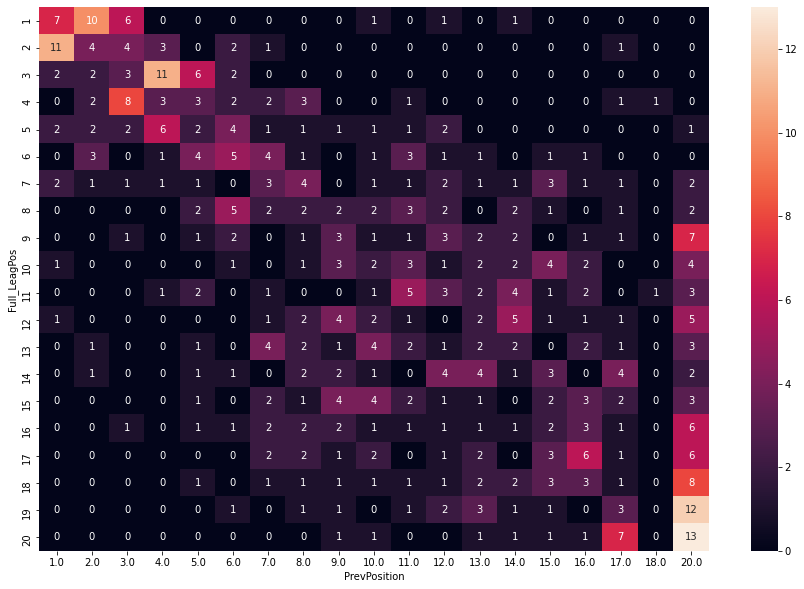

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pd.pivot_table(data=fin_pos.groupby(['Full_LeagPos', 'PrevPosition']).count(), columns='PrevPosition', index='Full_LeagPos', values='Season', fill_value=0), annot=True, ax=ax);

Heatmap shows:
 - We have a clustering of top performing teams that tend to remain top performing teams
 - The middle of the table (5-15) has a bit of movement
 - Teams that get promoted from the season before tend to perform very poorly (and get relegated again)

__Potentially suggests we can reduce the dimensionality of this variable to be top, middle and bottom__

In [22]:
fin_pos[(fin_pos.Full_LeagPos == 1) & (fin_pos.PrevPosition > 8)]

,Full_LeagPos,Season,PrevPosition
Team,,,
Leicester,1,2015/2016,14.0
Chelsea,1,2016/2017,10.0
Everton,1,2020/2021,12.0


The above shows the ascent of Leicester and even Chelsea in 2016/2017 following a poor prev season - suggests maybe 2 seasons of history potentially useful or avg of last 5?

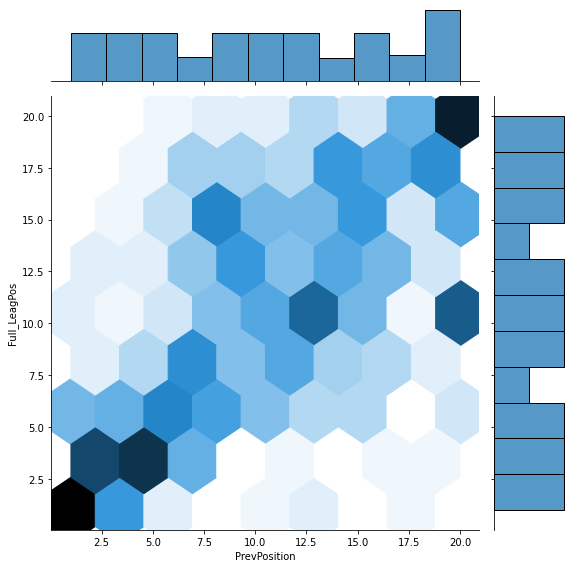

In [23]:
sns.jointplot(data=fin_pos, x='PrevPosition', y='Full_LeagPos', kind='hex', height=8);

Create a variable for the differntial in league finishing position in the previous season and current season

In [24]:
df_pos_diff = df.copy()

# df_pos_diff = df_pos_diff[df_pos_diff.Season.isin(df.Season.unique()[-10:-5])]

df_pos_diff['HomePrevLeagPos'] = np.where(df_pos_diff['HomePrevLeagPos'] == 'P', 20, df_pos_diff['HomePrevLeagPos'])
df_pos_diff['AwayPrevLeagPos'] = np.where(df_pos_diff['AwayPrevLeagPos'] == 'P', 20, df_pos_diff['AwayPrevLeagPos'])

df_pos_diff['HomePrevPosMinAwayPrevPos'] = df_pos_diff['HomePrevLeagPos'] - df_pos_diff['AwayPrevLeagPos']
df_pos_diff['HomePosMinAwayPos'] = df_pos_diff['HomeLeagPos'] - df_pos_diff['AwayLeagPos']
df_pos_diff = df_pos_diff[['Season', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HomeLeagPos', 'AwayLeagPos', 'HomePosMinAwayPos', 'HomePrevLeagPos', 'AwayPrevLeagPos', 'HomePrevPosMinAwayPrevPos']].dropna()
df_pos_diff.tail()

,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeLeagPos,AwayLeagPos,HomePosMinAwayPos,HomePrevLeagPos,AwayPrevLeagPos,HomePrevPosMinAwayPrevPos
10367,2020/2021,Wolves,Fulham,1.0,0.0,H,13.0,20.0,-7.0,7,20,-13
10368,2020/2021,Man United,Tottenham,1.0,6.0,A,14.0,6.0,8.0,3,6,-3
10369,2020/2021,Aston Villa,Liverpool,7.0,2.0,H,4.0,5.0,-1.0,17,1,16
10370,2020/2021,Southampton,West Brom,2.0,0.0,H,11.0,17.0,-6.0,11,20,-9
10371,2020/2021,Leicester,West Ham,0.0,3.0,A,3.0,10.0,-7.0,5,16,-11


#### 3b i. Last Season Perf Differential

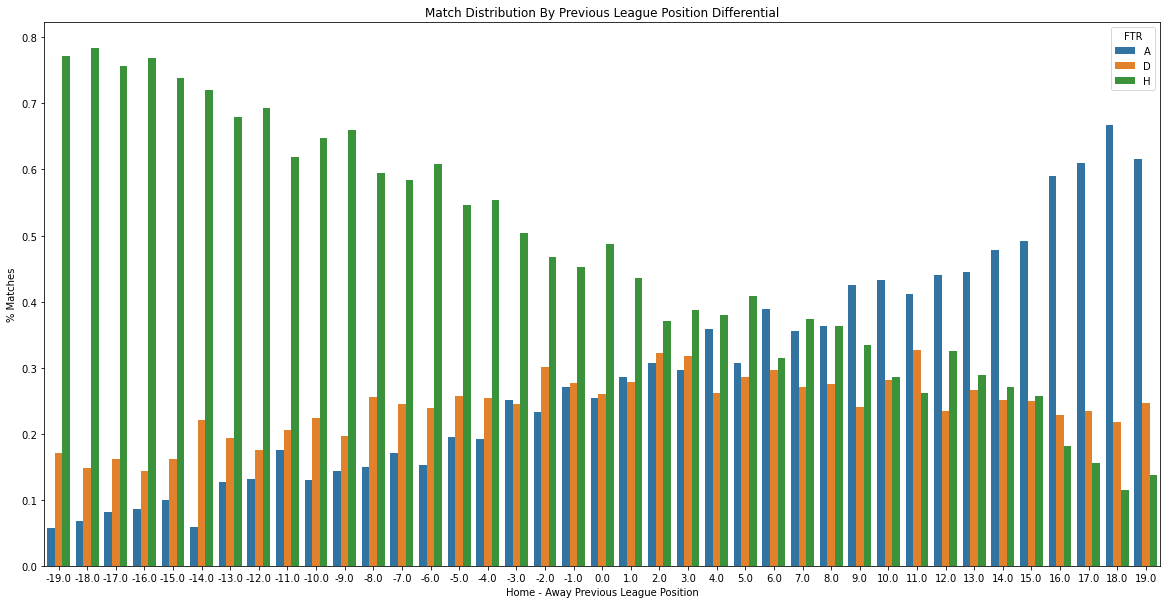

In [25]:
df_prev_pos_diff_chart_df = (df_pos_diff[['FTR', 'HomePrevPosMinAwayPrevPos', 'HomeTeam']].groupby(['FTR', 'HomePrevPosMinAwayPrevPos']).count() / df_pos_diff[['HomePrevPosMinAwayPrevPos', 'HomeTeam']].groupby(['HomePrevPosMinAwayPrevPos']).count()).reset_index()

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=df_prev_pos_diff_chart_df,
            x='HomePrevPosMinAwayPrevPos',
            y='HomeTeam',
            hue='FTR',
            ax=ax);
ax.set_title("Match Distribution By Previous League Position Differential");
ax.set_xlabel("Home - Away Previous League Position");
ax.set_ylabel("% Matches");

Seems like a pretty useful variable for pulling apart the data:
 - If the HomeTeam finished >12 places above the AwayTeam in the previous season they win around >70% of the time
 - Slight dampener on the reverse - if AwayTeam finished >12 places in prev season they win around 45-60% of the time
 - Draw is centred to teams in similar positions, but slightly skewed i.e. if team which finished slightly lower is at home they are more likely to draw than vice versa

#### 3b ii. Current Season Perf Differential

We can now look at the same but using the current season position differentials

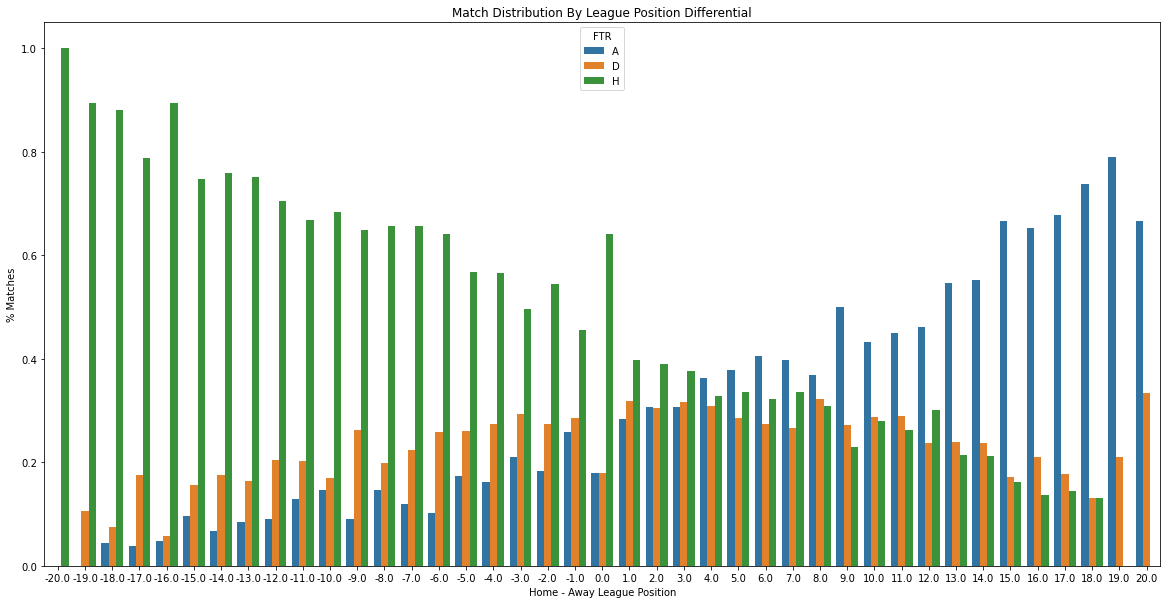

In [26]:
df_pos_diff_chart_df = (df_pos_diff[['FTR', 'HomePosMinAwayPos', 'HomeTeam']].groupby(['FTR', 'HomePosMinAwayPos']).count() / df_pos_diff[['HomePosMinAwayPos', 'HomeTeam']].groupby(['HomePosMinAwayPos']).count()).reset_index()

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=df_pos_diff_chart_df,
            x='HomePosMinAwayPos',
            y='HomeTeam',
            hue='FTR',
            ax=ax);
ax.set_title("Match Distribution By League Position Differential");
ax.set_xlabel("Home - Away League Position");
ax.set_ylabel("% Matches");

Very similar pattern to the previous season - means at the start of the season perhaps we can just rely on the previous season data to help

In [27]:
df_pos_diff_tab = pd.merge(left=df_prev_pos_diff_chart_df.rename(columns={'HomePrevPosMinAwayPrevPos': 'PosDifference', 'HomeTeam': 'Home_Win_Perc_Prev'}),
                           right=df_pos_diff_chart_df.rename(columns={'HomePosMinAwayPos': 'PosDifference', 'HomeTeam': 'Home_Win_Perc'}),
                           how='outer', left_on=['FTR', 'PosDifference'], right_on=['FTR', 'PosDifference']).fillna(0)

In [28]:
df_pos_diff_tab = pd.pivot_table(data=pd.melt(df_pos_diff_tab, id_vars=['FTR', 'PosDifference'], value_vars=['Home_Win_Perc_Prev', 'Home_Win_Perc'], var_name='SeasonDiff', value_name='GamePercentage'),
                                 columns='PosDifference',
                                 index=['SeasonDiff', 'FTR'],
                                 values='GamePercentage').sort_values(['SeasonDiff', 'FTR'], ascending=False).fillna(0)

df_pos_diff_tab.apply(lambda x: round(x*100))

PosDifference           -20.0  -19.0  -18.0  -17.0  -16.0  -15.0  -14.0  \
SeasonDiff         FTR                                                    
Home_Win_Perc_Prev H      0.0   77.0   78.0   76.0   77.0   74.0   72.0   
                   D      0.0   17.0   15.0   16.0   14.0   16.0   22.0   
                   A      0.0    6.0    7.0    8.0    9.0   10.0    6.0   
Home_Win_Perc      H    100.0   89.0   88.0   79.0   89.0   75.0   76.0   
                   D      0.0   11.0    7.0   18.0    6.0   16.0   17.0   
                   A      0.0    0.0    4.0    4.0    5.0   10.0    7.0   

PosDifference           -13.0  -12.0  -11.0  -10.0  -9.0   -8.0   -7.0   \
SeasonDiff         FTR                                                    
Home_Win_Perc_Prev H     68.0   69.0   62.0   65.0   66.0   59.0   58.0   
                   D     19.0   18.0   21.0   22.0   20.0   25.0   25.0   
                   A     13.0   13.0   18.0   13.0   14.0   15.0   17.0   
Home_Win_Perc      H     75.0   70.0   67.0   68.0   65.0   66.0   66.0   
                   D     16.0   20.0   20.0   17.0   26.0   20.0   22.0   
                   A      8.0    9.0   13.0   15.0    9.0   15.0   12.0   

PosDifference           -6.0   -5.0   -4.0   -3.0   -2.0   -1.0    0.0   \
SeasonDiff         FTR                                                    
Home_Win_Perc_Prev H     61.0   55.0   55.0   50.0   47.0   45.0   49.0   
                   D     24.0   26.0   25.0   24.0   30.0   28.0   26.0   
                   A     15.0   20.0   19.0   25.0   23.0   27.0   25.0   
Home_Win_Perc      H     64.0   57.0   56.0   50.0   54.0   46.0   64.0   
                   D     26.0   26.0   27.0   29.0   27.0   29.0   18.0   
                   A     10.0   17.0   16.0   21.0   18.0   26.0   18.0   

PosDifference            1.0    2.0    3.0    4.0    5.0    6.0    7.0   \
SeasonDiff         FTR                                                    
Home_Win_Perc_Prev H     44.0   37.0   39.0   38.0   41.0   31.0   37.0   
                   D     28.0   32.0   32.0   26.0   29.0   30.0   27.0   
                   A     29.0   31.0   30.0   36.0   31.0   39.0   36.0   
Home_Win_Perc      H     40.0   39.0   38.0   33.0   34.0   32.0   34.0   
                   D     32.0   30.0   32.0   31.0   29.0   27.0   27.0   
                   A     28.0   31.0   31.0   36.0   38.0   40.0   40.0   

PosDifference            8.0    9.0    10.0   11.0   12.0   13.0   14.0  \
SeasonDiff         FTR                                                    
Home_Win_Perc_Prev H     36.0   33.0   29.0   26.0   32.0   29.0   27.0   
                   D     28.0   24.0   28.0   33.0   24.0   27.0   25.0   
                   A     36.0   42.0   43.0   41.0   44.0   44.0   48.0   
Home_Win_Perc      H     31.0   23.0   28.0   26.0   30.0   21.0   21.0   
                   D     32.0   27.0   29.0   29.0   24.0   24.0   24.0   
                   A     37.0   50.0   43.0   45.0   46.0   55.0   55.0   

PosDifference            15.0   16.0   17.0   18.0   19.0   20.0  
SeasonDiff         FTR                                            
Home_Win_Perc_Prev H     26.0   18.0   16.0   12.0   14.0    0.0  
                   D     25.0   23.0   23.0   22.0   25.0    0.0  
                   A     49.0   59.0   61.0   67.0   62.0    0.0  
Home_Win_Perc      H     16.0   14.0   14.0   13.0    0.0    0.0  
                   D     17.0   21.0   18.0   13.0   21.0   33.0  
                   A     67.0   65.0   68.0   74.0   79.0   67.0

### 3c. Form - Comparing Recent Results

We can compute the results for the Home and Away teams for each match - how correlated are they to the outcome?

We can compare the difference in W streak across different teams and bin them like that

In [29]:
# add many streak variables
df_streak = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HomeTeamGameWeek', 'AwayTeamGameWeek', 'HomeLeagPos', 'HomePrevLeagPos', 'AwayLeagPos', 'AwayPrevLeagPos']]
df_streak = add_result_streak(df_streak, 3)
df_streak = add_result_streak(df_streak, 5)
df_streak = add_result_streak(df_streak, 10)
df_streak = add_result_streak(df_streak, 20)
df_streak[[x for x in df_streak.columns if "LStreak" not in x and "DStreak" not in x]].tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek,HomeLeagPos,HomePrevLeagPos,AwayLeagPos,AwayPrevLeagPos,HomeWStreak_3,AwayWStreak_3,HomeWStreak_5,AwayWStreak_5,HomeWStreak_10,AwayWStreak_10,HomeWStreak_20,AwayWStreak_20
10367,2020-10-04,Wolves,Fulham,1.0,0.0,H,4.0,4.0,13.0,7,20.0,P,0.333333,0.000000,0.4,0.0,0.4,0.3,0.45,0.20
10368,2020-10-04,Man United,Tottenham,1.0,6.0,A,3.0,4.0,14.0,3,6.0,6,0.666667,0.333333,0.6,0.4,0.7,0.5,0.55,0.45
10369,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H,3.0,4.0,4.0,17,5.0,1,0.666667,1.000000,0.6,1.0,0.4,0.7,0.30,0.75
10370,2020-10-04,Southampton,West Brom,2.0,0.0,H,4.0,4.0,11.0,11,17.0,P,0.333333,0.000000,0.6,0.2,0.5,0.3,0.45,0.20
10371,2020-10-04,Leicester,West Ham,0.0,3.0,A,4.0,4.0,3.0,5,10.0,16,1.000000,0.333333,0.6,0.2,0.5,0.4,0.35,0.25


In [30]:
# create league differential cols
df_streak['HomePrevLeagPos'] = np.where(df_streak['HomePrevLeagPos'] == 'P', 20, df_streak['HomePrevLeagPos'])
df_streak['AwayPrevLeagPos'] = np.where(df_streak['AwayPrevLeagPos'] == 'P', 20, df_streak['AwayPrevLeagPos'])

df_streak['HomePrevPosMinAwayPrevPos'] = df_streak['HomePrevLeagPos'] - df_streak['AwayPrevLeagPos']
df_streak['HomePosMinAwayPos'] = df_streak['HomeLeagPos'] - df_streak['AwayLeagPos']

In [31]:
def create_streak_heatmap(df_streak, streak_length):
    
    h_s = 'HomeWStreak_' + str(streak_length)
    a_s = 'AwayWStreak_' + str(streak_length)
    df_streak['WinStreakDiff'] = df_streak[h_s] - df_streak[a_s]
    
    # bin the win streak differentials into 5 cats
    df_streak['WinStreakDiffBin'] = np.where(df_streak['WinStreakDiff'] <= -0.8, "5_AwayHot", np.nan)
    df_streak['WinStreakDiffBin'] = np.where((df_streak['WinStreakDiff'] > -0.8) & (df_streak['WinStreakDiff'] <= -0.4), "4_AwayBias", df_streak['WinStreakDiffBin'])
    df_streak['WinStreakDiffBin'] = np.where((df_streak['WinStreakDiff'] > -0.4) & (df_streak['WinStreakDiff'] <= 0.2), "3_Evens", df_streak['WinStreakDiffBin'])
    df_streak['WinStreakDiffBin'] = np.where((df_streak['WinStreakDiff'] > 0.2) & (df_streak['WinStreakDiff'] <= 0.6), "2_HomeBias", df_streak['WinStreakDiffBin'])
    df_streak['WinStreakDiffBin'] = np.where(df_streak['WinStreakDiff'] > 0.6, "1_HomeHot", df_streak['WinStreakDiffBin'])

    # bin the table differentials into 5 cats
    df_streak['TabDiffBin'] = np.where(df_streak['HomePosMinAwayPos'] <= -14, "1_HomeDom", np.nan)
    df_streak['TabDiffBin'] = np.where((df_streak['HomePosMinAwayPos'] > -14) & (df_streak['HomePosMinAwayPos'] <= -6), "2_HomeBias", df_streak['TabDiffBin'])
    df_streak['TabDiffBin'] = np.where((df_streak['HomePosMinAwayPos'] > -6) & (df_streak['HomePosMinAwayPos'] <= 5), "3_Evens", df_streak['TabDiffBin'])
    df_streak['TabDiffBin'] = np.where((df_streak['HomePosMinAwayPos'] > 5) & (df_streak['HomePosMinAwayPos'] <= 13), "4_AwayBias", df_streak['TabDiffBin'])
    df_streak['TabDiffBin'] = np.where(df_streak['HomePosMinAwayPos'] > 13, "5_AwayDom", df_streak['TabDiffBin'])

    # piv
    df_streak_piv = (df_streak[['FTR', 'WinStreakDiffBin', 'TabDiffBin', 'HomeTeam']].groupby(['FTR', 'WinStreakDiffBin', 'TabDiffBin']).count() / df_streak[['WinStreakDiffBin', 'TabDiffBin', 'HomeTeam']].groupby(['WinStreakDiffBin', 'TabDiffBin']).count()).reset_index()
    df_streak_piv = df_streak_piv[(df_streak_piv.WinStreakDiffBin != 'nan') & (df_streak_piv.TabDiffBin != 'nan')].fillna(0)
    
    fig, ax = plt.subplots(ncols=3, figsize=(30, 7.5))

    for res in  ['H', 'D', 'A']:
        sns.heatmap(pd.pivot_table(data=df_streak_piv[df_streak_piv.FTR == res],
                                   index='WinStreakDiffBin',
                                   columns='TabDiffBin',
                                   values='HomeTeam').fillna(0),
                    annot=True,
                    vmin=0, vmax=1,
                    ax=ax[['H', 'D', 'A'].index(res)]);
    plt.suptitle('Heatmap of % Games: WinStreak of {} vs Current Season Table Position Difference'.format(streak_length), fontsize=14)
    
    return None

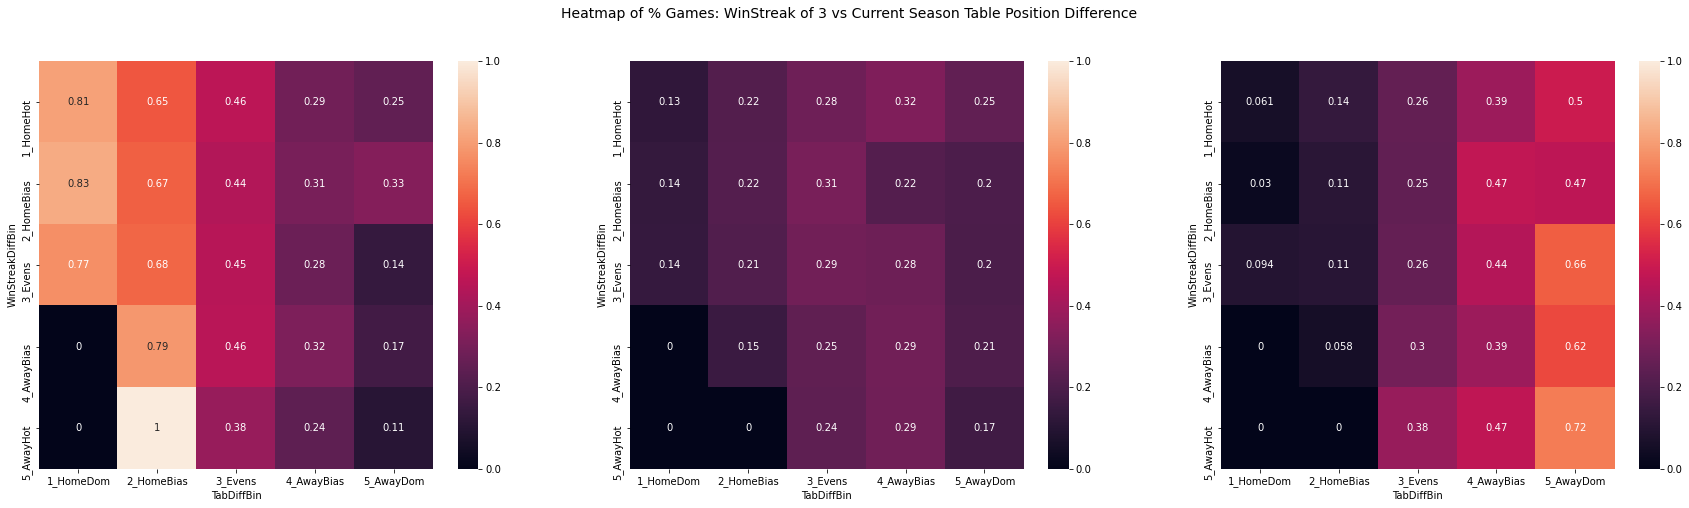

In [32]:
create_streak_heatmap(df_streak, 3)

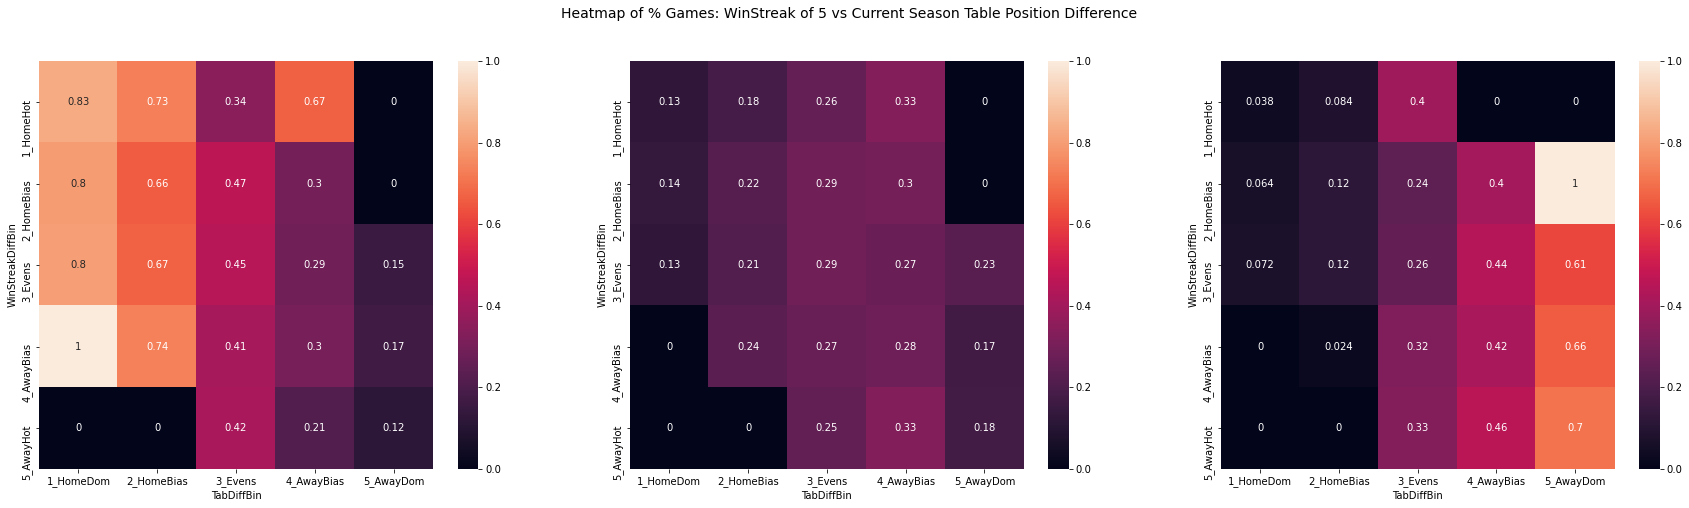

In [33]:
create_streak_heatmap(df_streak, 5)

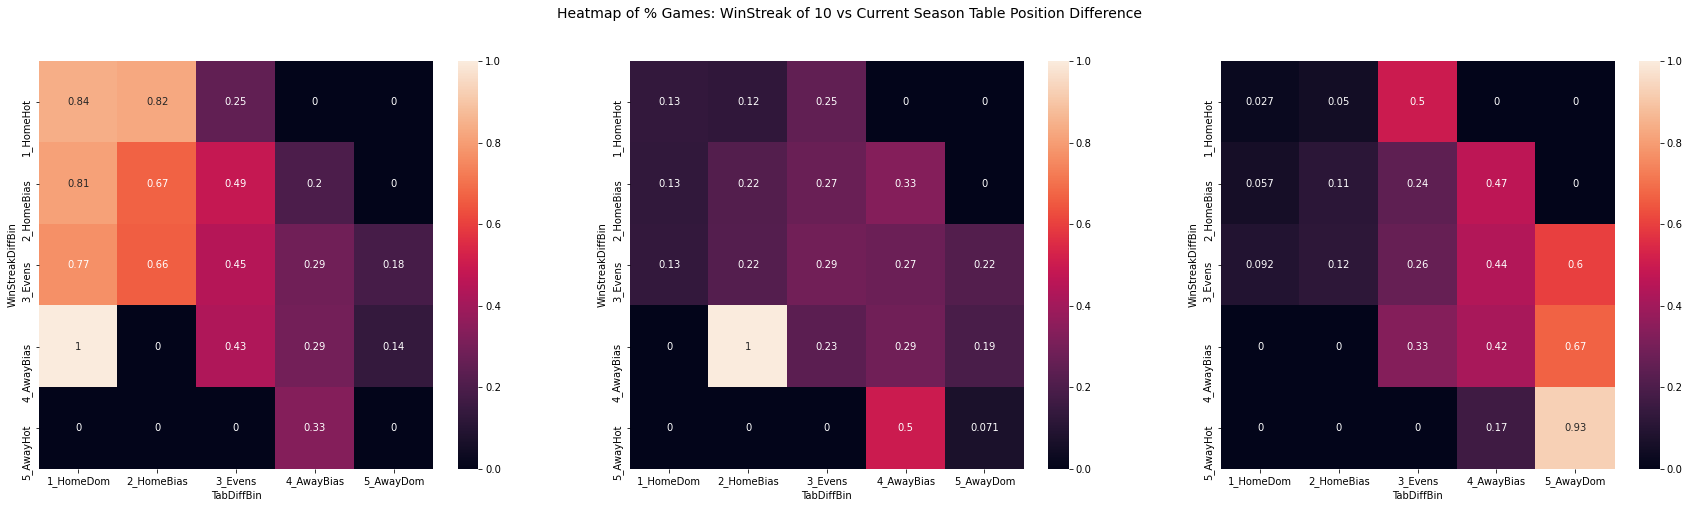

In [34]:
create_streak_heatmap(df_streak, 10)

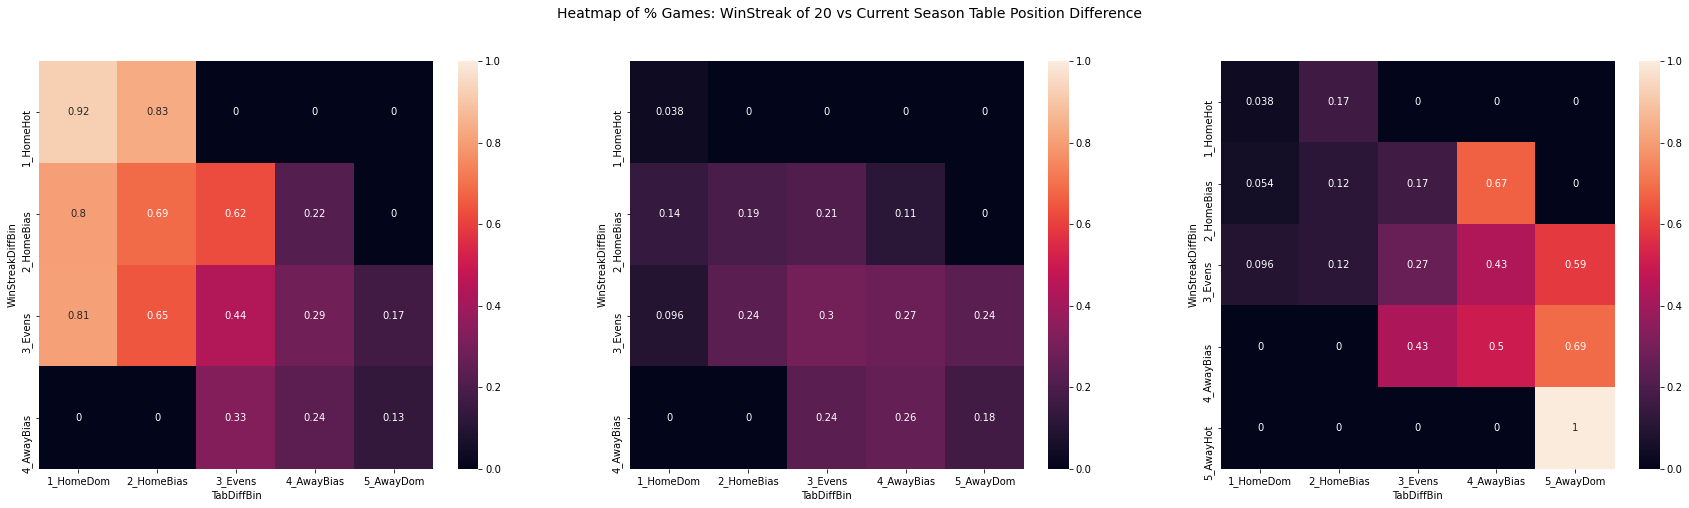

In [35]:
create_streak_heatmap(df_streak, 20)

Results:
 - Looks like the longer run measures of performance are more discriminatory for W or L --> makes sense as teams dominating
 - Draw is still very hard to tease apart with most areas very similar probability
 - Makes sense to include a measure of short and long term perf

To Do:
 - Build a random classifier model and test results
 - Build a logistic classifier model
 - Build a decision tree classifier model
 - Build a random forest classifier model
 
Questions to be answered:
 - Does how a team performed 5 seasons ago matter? Once we have conditioned on prev 1-2 seasons, does it matter?
 - Which factor is the most useful for classifying?
 - What is the optimal form feature? Last game? 3 games? 5 games? 10 games? Some combination?
 - Does number of clean sheets / avg of goals conceded / goals scored in last few games matter?
 - Does it matter whether or not we average of exponentially weight these quantities for previous games?